In [7]:
# 1. Import delle librerie
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

import os
model_path = os.path.abspath("./ald6_pbt_checkpoints/best_model")

# 3. Carica modello e tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [8]:
class UtteranceHatDataset(Dataset):
    def __init__(self, json_file_path, tokenizer, label_mapping, max_length=512):
        self.texts = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_length = max_length

        with open(json_file_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        for item in data:
            if 'utterance' in item and 'hat' in item:
                self.texts.append(item['utterance'])
                self.labels.append(label_mapping(item['hat']))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [9]:
def hat_to_label(hat):
    mapping = {
        "red": 0,
        "white": 1,
        "black": 2,
        "yellow": 3,
        "green": 4
    }
    if isinstance(hat, int):
        return hat
    return mapping.get(hat.lower(), 0)

In [14]:
# Percorso del nuovo dataset
new_dataset_path = "/home/atlas/hlt/HLT/Models Fine Tuning/synthetic_test_dataset.json"

# Crea il dataset e dataloader
test_dataset = UtteranceHatDataset(new_dataset_path, tokenizer, hat_to_label)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Valutazione del modello
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Accuracy: 0.49436936936936937
Classification Report:
               precision    recall  f1-score   support

         red       0.87      0.53      0.66       170
       white       0.22      0.22      0.22       157
       black       0.38      0.74      0.50       175
      yellow       0.56      0.18      0.27       193
       green       0.68      0.78      0.72       193

    accuracy                           0.49       888
   macro avg       0.54      0.49      0.47       888
weighted avg       0.55      0.49      0.48       888

Kappa di Cohen: 0.3685000784005651


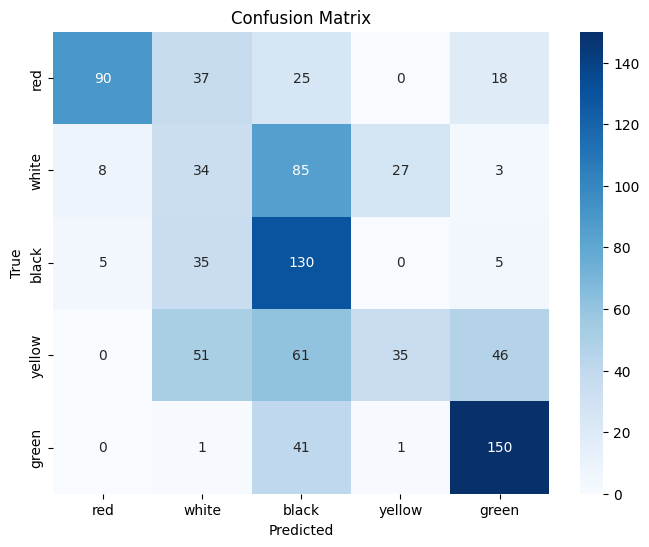

In [15]:
labels = ["red", "white", "black", "yellow", "green"]
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=labels))
print("Kappa di Cohen:", cohen_kappa_score(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()